In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import keras
import random
import shutil
from matplotlib.image import imread
from pathlib import Path
import shutil
import random
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout,BatchNormalization,Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import files
files.upload()

Saving kaggle-4.json to kaggle-4.json


{'kaggle-4.json': b'{"username":"testkaggle123123","key":"3012faec5be70d0a7299c41cd95e6ed5"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d azharn/alligator-vs-crocodile1

Dataset URL: https://www.kaggle.com/datasets/azharn/alligator-vs-crocodile1
License(s): CC0-1.0
 99% 171M/172M [00:09<00:00, 24.2MB/s]
100% 172M/172M [00:09<00:00, 18.4MB/s]


In [ ]:
zip_ref = zipfile.ZipFile('/content/alligator-vs-crocodile1.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
def count_files(directory):
  return sum(1 for f in Path(directory).iterdir() if f.is_file())

In [ ]:
for category in ["training", "testing"]:
    path = Path(category)
    path.mkdir(parents=True, exist_ok=True)
print("Folders created successfully!")

Folders created successfully!


In [ ]:
def load_and_fix_image(image_path):
    try:
        img = Image.open(image_path).convert("RGB")
        img.save(image_path)
        return True
    except Exception as e:
        print(f"File rusak atau tidak valid: {image_path} - {e}")
        return False

def moveFileToPath(base_path, category):
    base = Path(base_path)
    source_path = base / category
    train_path = Path("training") / category
    test_path = Path("testing") / category

    train_path.mkdir(parents=True, exist_ok=True)
    test_path.mkdir(parents=True, exist_ok=True)

    allowed_extensions = {".jpg", ".jpeg", ".png"}
    files = [f for f in source_path.iterdir() if f.is_file() and f.suffix.lower() in allowed_extensions]

    if not files:
        print(f"Tidak ada file gambar valid di kategori {category}.")
        return
    valid_files = [f for f in files if load_and_fix_image(f)]

    if not valid_files:
        print(f"Semua file dalam kategori {category} rusak atau tidak valid!")
        return

    random.shuffle(valid_files)
    train_count = int(len(valid_files) * 0.8)

    for file in valid_files[:train_count]:
        shutil.move(str(file), str(train_path / file.name))

    for file in valid_files[train_count:]:
        shutil.move(str(file), str(test_path / file.name))

    print(f"{category}: {train_count} files moved to training, {len(valid_files) - train_count} to testing.")

moveFileToPath("alligator vs crocodile", "alligator")
moveFileToPath("alligator vs crocodile", "crocodile")

alligator: 1376 files moved to training, 344 to testing.
crocodile: 1580 files moved to training, 396 to testing.


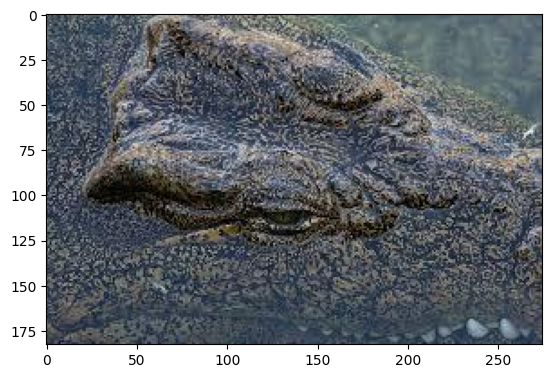

In [ ]:
test = "/content/testing/alligator/alligator1.jpg"
plt.imshow(imread(test))

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/training',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    '/content/testing',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

Found 2956 images belonging to 2 classes.
Found 740 images belonging to 2 classes.


Image batch shape: (32, 128, 128, 3)
Label batch shape: (32,)


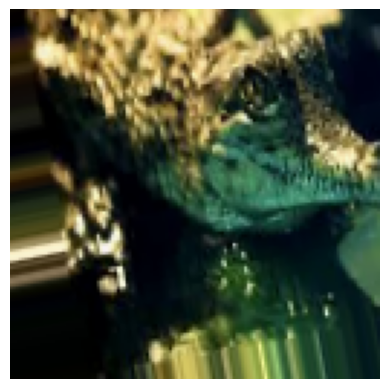

In [ ]:
image_batch, labels_batch = next(train_generator)

print("Image batch shape:", image_batch.shape)
print("Label batch shape:", labels_batch.shape)

plt.imshow(image_batch[0])
plt.axis("off")
plt.show()

In [ ]:
Model = Sequential()

Model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(256,256,3)))
Model.add(MaxPooling2D(pool_size=(2,2), strides=1, padding='valid'))

Model.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'))
Model.add(MaxPooling2D(pool_size=(2,2), strides=1, padding='valid'))

Model.add(Conv2D(256, kernel_size=(3,3), padding='valid', activation='relu'))
Model.add(MaxPooling2D(pool_size=(2,2), strides=1, padding='valid'))

Model.add(GlobalAveragePooling2D())

Model.add(Dense(128, activation='relu'))
Model.add(Dropout(0.5))
Model.add(Dense(1, activation='sigmoid'))

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
optimizer = Adam(learning_rate=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
Model.compile(loss = 'binary_crossentropy',optimizer = optimizer,metrics = ['accuracy'])

In [ ]:
Model.fit(train_generator ,validation_data=test_generator ,epochs = 50, callbacks=[early_stop, reduce_lr], steps_per_epoch=150)

Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.5878 - loss: 0.6724 - val_accuracy: 0.5730 - val_loss: 0.6774 - learning_rate: 5.0000e-05
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - accuracy: 0.5878 - loss: 0.6749 - val_accuracy: 0.5905 - val_loss: 0.6691 - learning_rate: 5.0000e-05
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.5919 - loss: 0.6720 - val_accuracy: 0.5716 - val_loss: 0.6791 - learning_rate: 5.0000e-05
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 127ms/step - accuracy: 0.5905 - loss: 0.6725 - val_accuracy: 0.5770 - val_loss: 0.6792 - learning_rate: 5.0000e-05
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 128ms/step - accuracy: 0.5770 - loss: 0.6744 - val_accuracy: 0.5865 - val_loss: 0.6682 - learning_rate: 5.0000e-05
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.5764 - loss: 0.6742 - val_accuracy: 0.5784 - val_loss: 0.6760 - learning_rate: 5.0000e-05
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 13

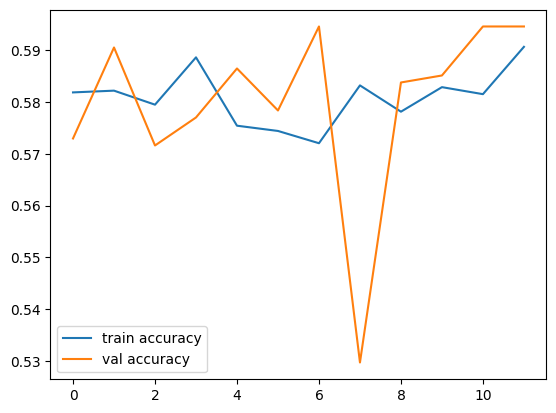

In [ ]:
plt.plot(Model.history.history['accuracy'],label = 'train accuracy')
plt.plot(Model.history.history['val_accuracy'],label = 'val accuracy')
plt.legend()
plt.show()

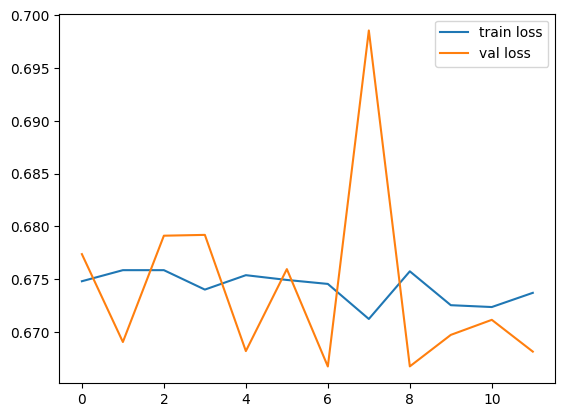

In [ ]:
plt.plot(Model.history.history['loss'],label = 'train loss')
plt.plot(Model.history.history['val_loss'],label = 'val loss')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
import os
converter = tf.lite.TFLiteConverter.from_keras_model(Model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

model_path = 'model-rian.tflite'
with open(model_path, 'wb') as f:
    f.write(tflite_model)

size_in_bytes = os.path.getsize(model_path)
size_in_kb = size_in_bytes / 1024
size_in_mb = size_in_kb / 1024

print(f"Quantized Model Size: {size_in_kb:.2f} KB ({size_in_mb:.2f} MB)")

NameError: name 'Model' is not defined

Expected input shape: [  1 256 256   3]
Actual input shape: (1, 256, 256, 3)


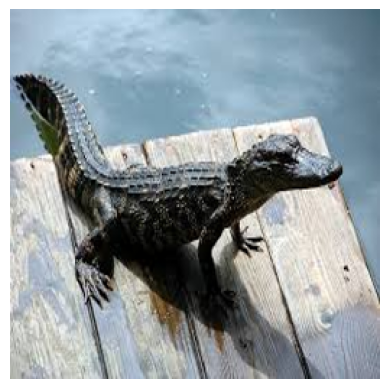

Raw model output: [[0.5082022]]
Predicted Class: crocodile (0.5082)


In [ ]:
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

interpreter = tf.lite.Interpreter(model_path="/content/model-rian.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

image_path = '/content/crocodile2.jpeg'
img = Image.open(image_path)

input_shape = input_details[0]['shape']
target_height, target_width = input_shape[1], input_shape[2]
expected_channels = input_shape[3]

img = img.resize((target_width, target_height))

img_array = np.array(img).astype(np.float32) / 255.0

if expected_channels == 1:
    img_array = np.mean(img_array, axis=-1, keepdims=True)

img_array = np.expand_dims(img_array, axis=0)

print(f"Expected input shape: {input_shape}")
print(f"Actual input shape: {img_array.shape}")

plt.imshow(img)
plt.axis('off')
plt.show()
interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()

predictions = interpreter.get_tensor(output_details[0]['index'])

probability = predictions[0][0]

class_labels = ['alligator', 'crocodile']

predicted_class = 1 if probability >= 0.5 else 0
predicted_label = class_labels[predicted_class]
print(f"Raw model output: {predictions}")
print(f"Predicted Class: {predicted_label} ({probability:.4f})")